In [115]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

## Input

In [116]:
activate_plotly = True # turn expensive renderings on and off
threshold = 0.6 # 0.45 to find the upper left recangle

# Define the paths
# target_image_path = '3boxes_labels.png'
# target_image_path = '00_3boxes_labels_scaled.png' # default
# target_image_path = 'door_system.png' # version 1 for paper
target_image_path = 'door_system_after_preprocessing_big_padding.png' # version 2 for paper with scaled vertex
# target_image_path = 'system.png'
# target_image_path = '3boxes_grey_input.png'
# template_image_path = 'task_scaled3.png'
# template_image_path = 'task_white.png'
# template_image_path = 'task.png'
template_image_path = 'task_180_200.png'
# template_image_path = 'greytemplate.png'

target_img = cv2.imread(target_image_path)
template_img = cv2.imread(template_image_path)

img = target_img

## Template Matching

Use opencv template matching: https://docs.opencv.org/4.10.0/df/dfb/group__imgproc__object.html

In [117]:
# Apply template matching
res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED)

## Thresholding

### Threshold Template Matching

In [118]:
loc = np.where(res >= threshold)
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

Found 122 matches with a threshold of 0.6


### Analysis After Thresholding

In [119]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

## From Pixels to Boxes

### Bounding Boxes before Foreground check
Draw bounding boxes for every single matched template. (A 180x200 box for every single pixel)

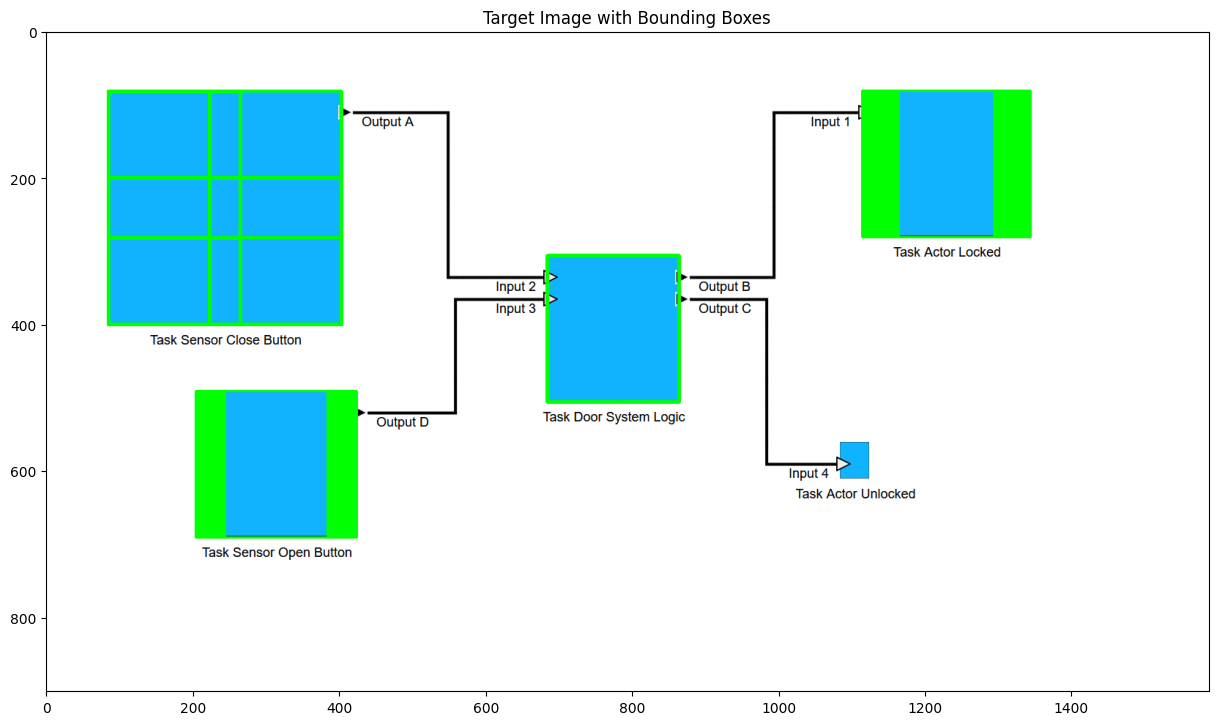

In [120]:
# Draw the bounding boxes
target_img_with_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0])
    cv2.rectangle(target_img_with_boxes, pt, bottom_right, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Bounding Boxes')  
plt.show()

### Threshold to get Foreground
Original target image is thresholded to get foreground. This is used to restrict matches to the foreground. TODO: is this still a thing?

In [121]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

### Filter Foreground
Filters the bounding boxes of the vertices. Only locations in the foreground are kept. This is probably obsolete. 

In [122]:
loc_foreground = []
for pt in zip(*loc[::-1]):
    if np.all(target_thresh[pt[1]:pt[1] + template_img.shape[0], pt[0]:pt[0] + template_img.shape[1]] == 255):
        loc_foreground.append(pt)

### Analyse Foreground Check
Foregound check has currently negligible effect and could be deactivated.

In [123]:
# Compare loc and loc_foreground
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")
print(f"Found {len(loc_foreground)} matches with a threshold of {threshold} and foreground filter")

Found 122 matches with a threshold of 0.6
Found 118 matches with a threshold of 0.6 and foreground filter


### Fill bounding boxes
Fills the bounding boxes of the vertices

In [124]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in zip(*loc[::-1]):
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), 255, -1)

### Find Contours in the super boxes
The overlapping bounding boxes are now puzzled together to big boxes

In [125]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours and save their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (0, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))

bounding_boxes = [(x-3, y-3, w+3, h+3) for (x, y, w, h) in bounding_boxes]

print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(201, 488, 224, 204), (680, 302, 186, 206), (1111, 78, 234, 204), (81, 78, 324, 324)]


#### functions

In [126]:
def is_line_inside_bounding_boxes(line, bounding_boxes):
    x1, y1, x2, y2 = line
    for (bx, by, bw, bh) in bounding_boxes:
        if (bx <= x1 <= bx + bw and by <= y1 <= by + bh) or (bx <= x2 <= bx + bw and by <= y2 <= by + bh):
            return True
    return False

def snap_to_90_degrees(line):
    x1, y1, x2, y2 = line
    if abs(x2 - x1) > abs(y2 - y1):
        # Snap to horizontal
        y2 = y1
    else:
        # Snap to vertical
        x2 = x1
    return (x1, y1, x2, y2)

def merge_lines(lines, min_distance=20, min_angle=10):
    merged_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        merged = False
        for merged_line in merged_lines:
            mx1, my1, mx2, my2 = merged_line
            if np.linalg.norm((x1 - mx1, y1 - my1)) < min_distance or np.linalg.norm((x2 - mx2, y2 - my2)) < min_distance:
                angle1 = np.arctan2(y2 - y1, x2 - x1)
                angle2 = np.arctan2(my2 - my1, mx2 - mx1)
                if abs(angle1 - angle2) < np.deg2rad(min_angle):
                    merged_line[0] = min(x1, mx1)
                    merged_line[1] = min(y1, my1)
                    merged_line[2] = max(x2, mx2)
                    merged_line[3] = max(y2, my2)
                    merged = True
                    break
        if not merged:
            merged_lines.append([x1, y1, x2, y2])
    return merged_lines

#### detecting lines
use bounding boxes to exclude lines from line detection algorythm

In [127]:
# Read image and convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

# Edge detection using Canny
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Hough Transform parameters
rho = 1  # Distance resolution in pixels
theta = np.pi / 180  # Angle resolution in radians
threshold = 15  # Accumulator threshold
min_line_length = 50  # Minimum line length
max_line_gap = 1  # Maximum gap between lines
line_image = np.copy(img) * 0  # Black image for lines

# Run Hough on edge detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Filter lines
filtered_lines = []
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            if not is_line_inside_bounding_boxes((x1, y1, x2, y2), bounding_boxes):
                # Filter out very short lines
                if np.linalg.norm((x2 - x1, y2 - y1)) > min_line_length:
                    filtered_lines.append((x1, y1, x2, y2))

# Merge lines
merged_lines = merge_lines(filtered_lines)

# Snap merged lines to 90 degrees
snapped_lines = [snap_to_90_degrees(line) for line in merged_lines]

# Draw snapped lines
for x1, y1, x2, y2 in snapped_lines:
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Draw the result
lines_edges = cv2.addWeighted(img, 0.9, line_image, 1, 0)

# Convert BGR to RGB for displaying with matplotlib
lines_edges_rgb = cv2.cvtColor(lines_edges, cv2.COLOR_BGR2RGB)

# Display the image in Jupyter Notebook
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(lines_edges_rgb)
plt.title('Lines Edges')
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Image')
plt.axis('off')  # Hide the axis

plt.show()

print("Filtered Lines:")
for i, (x1, y1, x2, y2) in enumerate(snapped_lines, start=1):
    print(f"Line {i}: ({x1}, {y1}) to ({x2}, {y2})")

KeyboardInterrupt: 

## post processing